# Data Preprocessing & Feature Engineering

**Author**: Novan  
**Date**: December 2024  
**Purpose**: Comprehensive preprocessing pipeline for diabetes clustering

---

## Notebook Overview

This notebook performs:
1. Data cleaning and missing value handling
2. Feature engineering (clinical, treatment, administrative)
3. Categorical encoding
4. Feature scaling
5. Data splitting (train/val/test)
6. Multi-perspective feature grouping
7. MLflow logging

## 1. Setup and Load Data

In [23]:
# Setup
import sys
import os
from pathlib import Path

# Project root setup
notebook_dir = Path.cwd()
project_root = notebook_dir.parent if notebook_dir.name == 'notebooks' else notebook_dir
sys.path.insert(0, str(project_root))
os.chdir(project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
from datetime import datetime

warnings.filterwarnings('ignore')

# Custom imports
from src.data.data_loader import DiabetesDataLoader, set_random_seed, load_config
from src.data.preprocessing import DiabetesPreprocessor, create_feature_groups
from src.features.feature_engineering import DiabetesFeatureEngineer, engineer_features
# from src.utils.mlflow_utils import MLflowManager

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_context('paper')
sns.set_palette('husl')

# Set random seed
set_random_seed(42)

# Load config
config = load_config('config/config.yaml')

# Create directories
for d in ['reports/figures', 'reports/results', 'data/processed']:
    Path(d).mkdir(parents=True, exist_ok=True)

# Helper function
def save_fig(name, dpi=300):
    path = f'reports/figures/{name}'
    plt.savefig(path, dpi=dpi, bbox_inches='tight')
    print(f'✅ Saved: {path}')

print('✅ Setup complete!')
print(f'📁 Working in: {Path.cwd()}')
print(f'🕐 Timestamp: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')

INFO:src.data.data_loader:Random seed set to 42
INFO:src.data.data_loader:Configuration loaded from: config/config.yaml


✅ Setup complete!
📁 Working in: /Users/rzkynovan/datsci/diabetes_clustering
🕐 Timestamp: 2025-12-04 17:54:04


In [24]:
# Load raw data
print("Loading raw dataset...")
loader = DiabetesDataLoader()
df = loader.load_raw_data()

print(f"\n{'='*70}")
print("INITIAL DATASET")
print(f"{'='*70}")
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nFirst 5 rows:")
df.head()

INFO:src.data.data_loader:Loading dataset from data/raw/diabetic_data.csv


Loading raw dataset...


INFO:src.data.data_loader:Dataset loaded successfully with utf-8 encoding
INFO:src.data.data_loader:Dataset loaded: 101766 rows, 50 columns



INITIAL DATASET
Shape: 101,766 rows × 50 columns
Memory: 220.22 MB

First 5 rows:


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


## 2. Data Cleaning

In [25]:
# Initialize preprocessor
preprocessor = DiabetesPreprocessor(config)

# Identify column types
columns = preprocessor.identify_columns(df)

print(f"\n{'='*70}")
print("COLUMN CATEGORIZATION")
print(f"{'='*70}")
for category, cols in columns.items():
    if isinstance(cols, list):
        print(f"\n{category.upper()}: {len(cols)}")
        if len(cols) <= 10:
            for col in cols:
                print(f"  - {col}")
        else:
            for col in cols[:5]:
                print(f"  - {col}")
            print(f"  ... and {len(cols)-5} more")
    else:
        print(f"\n{category.upper()}: {cols}")

INFO:src.data.preprocessing:Identifying column types...
INFO:src.data.preprocessing:Column categorization:
INFO:src.data.preprocessing:  - ID columns: 18
INFO:src.data.preprocessing:  - High missing (>80%): 2
INFO:src.data.preprocessing:  - Numerical: 8
INFO:src.data.preprocessing:  - Categorical: 11
INFO:src.data.preprocessing:  - Binary: 0
INFO:src.data.preprocessing:  - Medication: 23



COLUMN CATEGORIZATION

ID_COLUMNS: 18
  - encounter_id
  - patient_nbr
  - admission_type_id
  - discharge_disposition_id
  - admission_source_id
  ... and 13 more

TARGET: readmitted

NUMERICAL: 8
  - time_in_hospital
  - num_lab_procedures
  - num_procedures
  - num_medications
  - number_outpatient
  - number_emergency
  - number_inpatient
  - number_diagnoses

CATEGORICAL: 11
  - race
  - gender
  - age
  - weight
  - payer_code
  ... and 6 more

BINARY: 0

HIGH_MISSING: 2
  - max_glu_serum
  - A1Cresult

MEDICATION: 23
  - metformin
  - repaglinide
  - nateglinide
  - chlorpropamide
  - glimepiride
  ... and 18 more


In [26]:
# Remove ID columns
print(f"\n{'='*70}")
print("REMOVING ID COLUMNS")
print(f"{'='*70}")

id_cols_to_remove = columns['id_columns']
if id_cols_to_remove:
    print(f"\nRemoving {len(id_cols_to_remove)} ID columns:")
    for col in id_cols_to_remove:
        print(f"  - {col}")
    df = df.drop(columns=id_cols_to_remove)
    print(f"\n✅ Shape after removing IDs: {df.shape}")
else:
    print("No ID columns to remove")


REMOVING ID COLUMNS

Removing 18 ID columns:
  - encounter_id
  - patient_nbr
  - admission_type_id
  - discharge_disposition_id
  - admission_source_id
  - repaglinide
  - nateglinide
  - chlorpropamide
  - glimepiride
  - acetohexamide
  - glipizide
  - glyburide
  - tolbutamide
  - tolazamide
  - examide
  - glyburide-metformin
  - glipizide-metformin
  - glimepiride-pioglitazone

✅ Shape after removing IDs: (101766, 32)


In [27]:
# Remove high-missing columns
print(f"\n{'='*70}")
print("REMOVING HIGH-MISSING COLUMNS (>80%)")
print(f"{'='*70}")

df = preprocessor.remove_high_missing_columns(df, threshold=0.8)
print(f"\n✅ Shape after removing high-missing: {df.shape}")

INFO:src.data.preprocessing:Removing 2 columns with >80.0% missing:
INFO:src.data.preprocessing:  - max_glu_serum: 94.75% missing
INFO:src.data.preprocessing:  - A1Cresult: 83.28% missing



REMOVING HIGH-MISSING COLUMNS (>80%)

✅ Shape after removing high-missing: (101766, 30)


In [28]:
# Check for duplicates
print(f"\n{'='*70}")
print("CHECKING FOR DUPLICATES")
print(f"{'='*70}")

n_duplicates = df.duplicated().sum()
print(f"\nDuplicate rows: {n_duplicates:,}")

if n_duplicates > 0:
    print(f"Removing {n_duplicates:,} duplicate rows...")
    df = df.drop_duplicates()
    print(f"✅ Shape after removing duplicates: {df.shape}")
else:
    print("✅ No duplicate rows found")


CHECKING FOR DUPLICATES

Duplicate rows: 0
✅ No duplicate rows found


## 3. Handle Missing Values

In [29]:
# Analyze remaining missing values
print(f"\n{'='*70}")
print("MISSING VALUES ANALYSIS")
print(f"{'='*70}")

missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

if len(missing) > 0:
    print(f"\nColumns with missing values: {len(missing)}")
    print(f"\n{'Column':<30s} {'Missing':<10s} {'Percentage':<10s}")
    print("-" * 50)
    for col, count in missing.items():
        pct = count / len(df) * 100
        print(f"{col:<30s} {count:<10,} {pct:<10.2f}%")
else:
    print("\n✅ No missing values!")


MISSING VALUES ANALYSIS

✅ No missing values!


In [30]:
# Handle missing values
print(f"\n{'='*70}")
print("HANDLING MISSING VALUES")
print(f"{'='*70}")

# Update column categorization after removals
columns = preprocessor.identify_columns(df)

df = preprocessor.handle_missing_values(df, columns)

# Verify no missing values remain
remaining_missing = df.isnull().sum().sum()
print(f"\n{'='*70}")
print(f"✅ Missing value handling complete")
print(f"Remaining missing values: {remaining_missing}")
print(f"Final shape: {df.shape}")
print(f"{'='*70}")

INFO:src.data.preprocessing:Identifying column types...



HANDLING MISSING VALUES


INFO:src.data.preprocessing:Column categorization:
INFO:src.data.preprocessing:  - ID columns: 0
INFO:src.data.preprocessing:  - High missing (>80%): 0
INFO:src.data.preprocessing:  - Numerical: 8
INFO:src.data.preprocessing:  - Categorical: 11
INFO:src.data.preprocessing:  - Binary: 0
INFO:src.data.preprocessing:  - Medication: 10
INFO:src.data.preprocessing:Handling missing values...


INFO:src.data.preprocessing:Remaining missing values: 0



✅ Missing value handling complete
Remaining missing values: 0
Final shape: (101766, 30)


In [31]:
# Encode medication columns BEFORE feature engineering
print(f"\n{'='*70}")
print("ENCODING MEDICATION COLUMNS")
print(f"{'='*70}")

# Identify medication columns
med_keywords = ['metformin', 'insulin', 'glyburide', 'glipizide', 'glimepiride',
                'pioglitazone', 'rosiglitazone', 'repaglinide', 'nateglinide',
                'chlorpropamide', 'tolbutamide', 'acarbose', 'miglitol',
                'troglitazone', 'tolazamide', 'examide', 'citoglipton',
                'glyburide-metformin', 'glipizide-metformin', 
                'glimepiride-pioglitazone', 'metformin-rosiglitazone',
                'metformin-pioglitazone']

medication_cols = [col for col in df.columns 
                  if any(med in col.lower() for med in med_keywords)]

print(f"\nFound {len(medication_cols)} medication columns")

# Medication encoding: No=0, Steady=1, Down=2, Up=3
medication_encoding = {'No': 0, 'Steady': 1, 'Down': 2, 'Up': 3}

for col in medication_cols:
    if col in df.columns and df[col].dtype == 'object':
        # Check unique values
        unique_vals = df[col].unique()
        print(f"\n{col}: {unique_vals}")
        
        # Encode
        df[col] = df[col].map(medication_encoding)
        
        # Handle any unmapped values
        if df[col].isnull().any():
            print(f"  Warning: {df[col].isnull().sum()} unmapped values, filling with 0 (No)")
            df[col].fillna(0, inplace=True)

print(f"\n✅ Medication encoding complete")
print(f"All medication columns are now numeric")



ENCODING MEDICATION COLUMNS

Found 10 medication columns

metformin: ['No' 'Steady' 'Up' 'Down']

pioglitazone: ['No' 'Steady' 'Up' 'Down']

rosiglitazone: ['No' 'Steady' 'Up' 'Down']

acarbose: ['No' 'Steady' 'Up' 'Down']

miglitol: ['No' 'Steady' 'Down' 'Up']

troglitazone: ['No' 'Steady']

citoglipton: ['No']

insulin: ['No' 'Up' 'Steady' 'Down']

metformin-rosiglitazone: ['No' 'Steady']

metformin-pioglitazone: ['No' 'Steady']

✅ Medication encoding complete
All medication columns are now numeric


## 4. Feature Engineering

In [32]:
# Feature engineering
print(f"\n{'='*70}")
print("FEATURE ENGINEERING")
print(f"{'='*70}")

shape_before = df.shape
print(f"\nShape before feature engineering: {shape_before}")

df, feature_summary = engineer_features(df, config)

shape_after = df.shape
print(f"\n{'='*70}")
print(f"✅ Feature engineering complete")
print(f"Shape after: {shape_after}")
print(f"New features: {shape_after[1] - shape_before[1]}")
print(f"{'='*70}")

INFO:src.features.feature_engineering:======================================================================
INFO:src.features.feature_engineering:FEATURE ENGINEERING STARTED
INFO:src.features.feature_engineering:======================================================================
INFO:src.features.feature_engineering:
1. Creating Clinical Features...
INFO:src.features.feature_engineering:   Created 12 clinical features:
INFO:src.features.feature_engineering:     - comorbidity_score
INFO:src.features.feature_engineering:     - comorbidity_low
INFO:src.features.feature_engineering:     - comorbidity_medium
INFO:src.features.feature_engineering:     - comorbidity_high
INFO:src.features.feature_engineering:     - has_secondary_diagnosis
INFO:src.features.feature_engineering:     - has_tertiary_diagnosis
INFO:src.features.feature_engineering:     - multiple_diagnoses
INFO:src.features.feature_engineering:     - lab_intensity_low
INFO:src.features.feature_engineering:     - lab_intensity_


FEATURE ENGINEERING

Shape before feature engineering: (101766, 30)


INFO:src.features.feature_engineering:   Created 16 treatment features:
INFO:src.features.feature_engineering:     - total_medications
INFO:src.features.feature_engineering:     - medication_changes_count
INFO:src.features.feature_engineering:     - medication_up_count
INFO:src.features.feature_engineering:     - medication_down_count
INFO:src.features.feature_engineering:     - poly_pharmacy
INFO:src.features.feature_engineering:     - medication_intensity_low
INFO:src.features.feature_engineering:     - medication_intensity_medium
INFO:src.features.feature_engineering:     - medication_intensity_high
INFO:src.features.feature_engineering:     - insulin_dependent
INFO:src.features.feature_engineering:     - insulin_increased
INFO:src.features.feature_engineering:     - on_metformin
INFO:src.features.feature_engineering:     - oral_agents_only
INFO:src.features.feature_engineering:     - medication_diversity
INFO:src.features.feature_engineering:     - diabetesMed_binary
INFO:src.featu


✅ Feature engineering complete
Shape after: (101766, 93)
New features: 63


In [33]:
# Display feature engineering summary
print(f"\n{'='*70}")
print("FEATURE ENGINEERING SUMMARY")
print(f"{'='*70}")

print(f"\nTotal features created: {feature_summary['total_features_created']}")

for group, features in feature_summary['feature_groups'].items():
    if features:
        print(f"\n{group.upper()}: {len(features)}")
        for feat in features[:10]:  # Show first 10
            print(f"  - {feat}")
        if len(features) > 10:
            print(f"  ... and {len(features)-10} more")


FEATURE ENGINEERING SUMMARY

Total features created: 63

CLINICAL: 14
  - comorbidity_score
  - comorbidity_low
  - comorbidity_medium
  - comorbidity_high
  - has_secondary_diagnosis
  - has_tertiary_diagnosis
  - lab_intensity_low
  - lab_intensity_medium
  - lab_intensity_high
  - clinical_complexity_score
  ... and 4 more

TREATMENT: 17
  - total_medications
  - medication_changes_count
  - medication_up_count
  - medication_down_count
  - medication_intensity_low
  - medication_intensity_medium
  - medication_intensity_high
  - insulin_dependent
  - insulin_increased
  - on_metformin
  ... and 7 more

ADMINISTRATIVE: 13
  - los_short
  - los_medium
  - los_long
  - los_very_long
  - total_visits
  - frequent_visitor
  - visit_diversity
  - has_emergency_visit
  - has_outpatient_visit
  - resource_utilization_score
  ... and 3 more

DEMOGRAPHIC: 17
  - oral_agents_only
  - age_numeric
  - age_young
  - age_middle
  - age_senior
  - age_elderly
  - gender_male
  - gender_female
  -

## 5. Save Checkpoint (Before Encoding)

In [34]:
# Save checkpoint
checkpoint_path = 'data/processed/01_after_feature_engineering.csv'
df.to_csv(checkpoint_path, index=False)
print(f"\n✅ Checkpoint saved: {checkpoint_path}")
print(f"Shape: {df.shape}")
print(f"Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


✅ Checkpoint saved: data/processed/01_after_feature_engineering.csv
Shape: (101766, 93)
Memory: 134.13 MB


In [35]:
# ============================================================================
# DIAGNOSTIC: Check Available Columns
# ============================================================================
print(f"\n{'='*70}")
print("DIAGNOSTIC: AVAILABLE COLUMNS")
print(f"{'='*70}")

# Load checkpoint
df = pd.read_csv('data/processed/01_after_feature_engineering.csv')
print(f"\nDataFrame shape: {df.shape}")

# Check which categorical columns exist
expected_categorical = [
    'gender', 'max_glu_serum', 'A1Cresult', 'change', 
    'diabetesMed', 'payer_code_group', 'admission_type_group',
    'medical_specialty', 'diag_1_category', 'diag_2_category', 'diag_3_category'
]

print(f"\n📋 Expected vs Available Categorical Columns:")
for col in expected_categorical:
    status = "✅" if col in df.columns else "❌"
    nunique = df[col].nunique() if col in df.columns else "N/A"
    print(f"  {status} {col}: {nunique} unique values")

# Show all column names
print(f"\n🔍 All columns ({len(df.columns)}):")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:3d}. {col}")

# Show data types
print(f"\n📊 Data Types:")
print(df.dtypes.value_counts())


DIAGNOSTIC: AVAILABLE COLUMNS

DataFrame shape: (101766, 93)

📋 Expected vs Available Categorical Columns:
  ✅ gender: 3 unique values
  ❌ max_glu_serum: N/A unique values
  ❌ A1Cresult: N/A unique values
  ✅ change: 2 unique values
  ✅ diabetesMed: 2 unique values
  ❌ payer_code_group: N/A unique values
  ❌ admission_type_group: N/A unique values
  ✅ medical_specialty: 73 unique values
  ❌ diag_1_category: N/A unique values
  ❌ diag_2_category: N/A unique values
  ❌ diag_3_category: N/A unique values

🔍 All columns (93):
    1. race
    2. gender
    3. age
    4. weight
    5. time_in_hospital
    6. payer_code
    7. medical_specialty
    8. num_lab_procedures
    9. num_procedures
   10. num_medications
   11. number_outpatient
   12. number_emergency
   13. number_inpatient
   14. diag_1
   15. diag_2
   16. diag_3
   17. number_diagnoses
   18. metformin
   19. pioglitazone
   20. rosiglitazone
   21. acarbose
   22. miglitol
   23. troglitazone
   24. citoglipton
   25. insulin

In [36]:
# ============================================================================
# 6. CATEGORICAL ENCODING
# ============================================================================
print(f"\n{'='*70}")
print("6. CATEGORICAL ENCODING")
print(f"{'='*70}")

# Load checkpoint
df = pd.read_csv('data/processed/01_after_feature_engineering.csv')
print(f"\n✅ Loaded checkpoint: {df.shape}")

# One-Hot Encoding for low-cardinality categorical features (yang ADA)
categorical_cols = ['gender', 'change', 'diabetesMed']

print(f"\n📊 One-Hot Encoding for {len(categorical_cols)} features:")
for col in categorical_cols:
    if col in df.columns:
        print(f"  - {col}: {df[col].nunique()} categories → {df[col].unique()}")

# Create dummy variables
df_encoded = pd.get_dummies(df, columns=categorical_cols, prefix=categorical_cols, drop_first=True)

print(f"\n✅ After One-Hot Encoding: {df_encoded.shape}")
print(f"   New columns added: {df_encoded.shape[1] - df.shape[1]}")

# Label Encoding for high-cardinality features
from sklearn.preprocessing import LabelEncoder

# Medical specialty (73 unique values) → Label Encoding
if 'medical_specialty' in df_encoded.columns:
    le_specialty = LabelEncoder()
    df_encoded['medical_specialty_encoded'] = le_specialty.fit_transform(
        df_encoded['medical_specialty'].astype(str)
    )
    # Keep original for interpretability, drop later if needed
    print(f"\n📊 Label Encoding:")
    print(f"  - medical_specialty: {len(le_specialty.classes_)} unique values → [0, {len(le_specialty.classes_)-1}]")
    
# Encode diagnosis columns (diag_1, diag_2, diag_3) - ICD9 codes
diagnosis_cols = ['diag_1', 'diag_2', 'diag_3']
for col in diagnosis_cols:
    if col in df_encoded.columns:
        le_diag = LabelEncoder()
        df_encoded[f'{col}_encoded'] = le_diag.fit_transform(
            df_encoded[col].astype(str)
        )
        print(f"  - {col}: {len(le_diag.classes_)} unique values → [0, {len(le_diag.classes_)-1}]")

# Encode payer_code (keep as-is since it's already processed)
if 'payer_code' in df_encoded.columns:
    le_payer = LabelEncoder()
    df_encoded['payer_code_encoded'] = le_payer.fit_transform(
        df_encoded['payer_code'].astype(str)
    )
    print(f"  - payer_code: {len(le_payer.classes_)} unique values → [0, {len(le_payer.classes_)-1}]")

# Encode race (if still object type)
if 'race' in df_encoded.columns and df_encoded['race'].dtype == 'object':
    le_race = LabelEncoder()
    df_encoded['race_encoded'] = le_race.fit_transform(
        df_encoded['race'].astype(str)
    )
    print(f"  - race: {len(le_race.classes_)} unique values → [0, {len(le_race.classes_)-1}]")

# Encode age (if still object type)
if 'age' in df_encoded.columns and df_encoded['age'].dtype == 'object':
    le_age = LabelEncoder()
    df_encoded['age_encoded'] = le_age.fit_transform(
        df_encoded['age'].astype(str)
    )
    print(f"  - age: {len(le_age.classes_)} unique values → [0, {len(le_age.classes_)-1}]")

# Encode weight (if still object type)
if 'weight' in df_encoded.columns and df_encoded['weight'].dtype == 'object':
    le_weight = LabelEncoder()
    df_encoded['weight_encoded'] = le_weight.fit_transform(
        df_encoded['weight'].astype(str)
    )
    print(f"  - weight: {len(le_weight.classes_)} unique values → [0, {len(le_weight.classes_)-1}]")

print(f"\n✅ Categorical Encoding Complete")
print(f"Final shape: {df_encoded.shape}")

# Drop original categorical columns (keep encoded versions)
cols_to_drop = []
for col in ['medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'payer_code', 'race', 'age', 'weight']:
    if col in df_encoded.columns and f'{col}_encoded' in df_encoded.columns:
        cols_to_drop.append(col)

if cols_to_drop:
    df_encoded.drop(columns=cols_to_drop, inplace=True)
    print(f"\n🗑️  Dropped {len(cols_to_drop)} original categorical columns:")
    print(f"   {cols_to_drop}")
    print(f"\nFinal shape after drop: {df_encoded.shape}")

# Verify all columns are numeric
print(f"\n🔍 Data Types After Encoding:")
print(df_encoded.dtypes.value_counts())

# Check for any remaining object columns
object_cols = df_encoded.select_dtypes(include=['object']).columns.tolist()
if object_cols:
    print(f"\n⚠️  WARNING: {len(object_cols)} object columns remain:")
    print(f"   {object_cols}")
else:
    print(f"\n✅ All columns are numeric - ready for scaling!")



6. CATEGORICAL ENCODING

✅ Loaded checkpoint: (101766, 93)

📊 One-Hot Encoding for 3 features:
  - gender: 3 categories → ['Female' 'Male' 'Unknown/Invalid']
  - change: 2 categories → ['No' 'Ch']
  - diabetesMed: 2 categories → ['No' 'Yes']

✅ After One-Hot Encoding: (101766, 94)
   New columns added: 1

📊 Label Encoding:
  - medical_specialty: 73 unique values → [0, 72]
  - diag_1: 717 unique values → [0, 716]
  - diag_2: 749 unique values → [0, 748]
  - diag_3: 790 unique values → [0, 789]
  - payer_code: 18 unique values → [0, 17]
  - race: 6 unique values → [0, 5]
  - age: 10 unique values → [0, 9]
  - weight: 10 unique values → [0, 9]

✅ Categorical Encoding Complete
Final shape: (101766, 102)

🗑️  Dropped 8 original categorical columns:
   ['medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'payer_code', 'race', 'age', 'weight']

Final shape after drop: (101766, 94)

🔍 Data Types After Encoding:
int64      82
float64     7
bool        4
object      1
Name: count, dtype: int64



In [37]:
# ============================================================================
# 7. DATA SPLITTING (STRATIFIED)
# ============================================================================
print(f"\n{'='*70}")
print("7. DATA SPLITTING (STRATIFIED)")
print(f"{'='*70}")

from sklearn.model_selection import train_test_split

# Separate features and target
X = df_encoded.drop('readmitted', axis=1)
y = df_encoded['readmitted']

print(f"\n📊 Dataset Info:")
print(f"  - Total samples: {len(X):,}")
print(f"  - Features: {X.shape[1]}")
print(f"  - Target distribution:")
for label, count in y.value_counts().items():
    print(f"      {label}: {count:,} ({count/len(y)*100:.1f}%)")

# Split: 70% train, 15% validation, 15% test (stratified)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp  # 0.1765 * 0.85 ≈ 0.15
)

print(f"\n✅ Split Complete:")
print(f"  - Train: {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)")
print(f"  - Validation: {len(X_val):,} ({len(X_val)/len(X)*100:.1f}%)")
print(f"  - Test: {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)")

# Verify stratification
print(f"\n📊 Stratification Verification:")
for split_name, y_split in [('Train', y_train), ('Val', y_val), ('Test', y_test)]:
    print(f"\n{split_name}:")
    for label, count in y_split.value_counts().sort_index().items():
        print(f"  {label}: {count:,} ({count/len(y_split)*100:.1f}%)")



7. DATA SPLITTING (STRATIFIED)

📊 Dataset Info:
  - Total samples: 101,766
  - Features: 93
  - Target distribution:
      NO: 54,864 (53.9%)
      >30: 35,545 (34.9%)
      <30: 11,357 (11.2%)

✅ Split Complete:
  - Train: 71,233 (70.0%)
  - Validation: 15,268 (15.0%)
  - Test: 15,265 (15.0%)

📊 Stratification Verification:

Train:
  <30: 7,950 (11.2%)
  >30: 24,880 (34.9%)
  NO: 38,403 (53.9%)

Val:
  <30: 1,704 (11.2%)
  >30: 5,333 (34.9%)
  NO: 8,231 (53.9%)

Test:
  <30: 1,703 (11.2%)
  >30: 5,332 (34.9%)
  NO: 8,230 (53.9%)


In [38]:
# ============================================================================
# 8. FEATURE SCALING
# ============================================================================
print(f"\n{'='*70}")
print("8. FEATURE SCALING")
print(f"{'='*70}")

from sklearn.preprocessing import RobustScaler, StandardScaler

# Identify numerical features
numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Features to scale with RobustScaler (outlier-resistant)
# - High skewness or outliers
robust_features = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures', 
    'num_medications', 'number_outpatient', 'number_emergency', 
    'number_inpatient', 'number_diagnoses', 
    'total_medications', 'total_visits', 'medication_changes_count',
    'medication_diversity', 'visit_diversity', 'resource_utilization_score',
    'clinical_complexity_score', 'treatment_complexity_score', 
    'complex_patient_score'
]
robust_features = [f for f in robust_features if f in numerical_features]

# Features to scale with StandardScaler (rest of numerical features)
standard_features = [f for f in numerical_features if f not in robust_features]

print(f"\n📊 Scaling Strategy:")
print(f"  - RobustScaler: {len(robust_features)} features (outlier-resistant)")
print(f"  - StandardScaler: {len(standard_features)} features")

# Initialize scalers
robust_scaler = RobustScaler()
standard_scaler = StandardScaler()

# Fit and transform
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

if robust_features:
    print(f"\n🔧 Applying RobustScaler to {len(robust_features)} features...")
    X_train_scaled[robust_features] = robust_scaler.fit_transform(X_train[robust_features])
    X_val_scaled[robust_features] = robust_scaler.transform(X_val[robust_features])
    X_test_scaled[robust_features] = robust_scaler.transform(X_test[robust_features])

if standard_features:
    print(f"🔧 Applying StandardScaler to {len(standard_features)} features...")
    X_train_scaled[standard_features] = standard_scaler.fit_transform(X_train[standard_features])
    X_val_scaled[standard_features] = standard_scaler.transform(X_val[standard_features])
    X_test_scaled[standard_features] = standard_scaler.transform(X_test[standard_features])

print(f"\n✅ Scaling Complete")
print(f"   Train: {X_train_scaled.shape}")
print(f"   Val: {X_val_scaled.shape}")
print(f"   Test: {X_test_scaled.shape}")

# Verify scaling
print(f"\n📊 Scaling Verification (Train Set):")
if robust_features:
    print(f"\nRobustScaler features (median ≈ 0, IQR ≈ 1):")
    sample_robust = X_train_scaled[robust_features[:3]].describe().loc[['mean', '50%', 'std']]
    print(sample_robust.round(3))

if standard_features:
    print(f"\nStandardScaler features (mean ≈ 0, std ≈ 1):")
    sample_standard = X_train_scaled[standard_features[:3]].describe().loc[['mean', 'std']]
    print(sample_standard.round(3))



8. FEATURE SCALING

📊 Scaling Strategy:
  - RobustScaler: 17 features (outlier-resistant)
  - StandardScaler: 72 features

🔧 Applying RobustScaler to 17 features...
🔧 Applying StandardScaler to 72 features...

✅ Scaling Complete
   Train: (71233, 93)
   Val: (15268, 93)
   Test: (15265, 93)

📊 Scaling Verification (Train Set):

RobustScaler features (median ≈ 0, IQR ≈ 1):
      time_in_hospital  num_lab_procedures  num_procedures
mean             0.100              -0.035           0.173
50%              0.000               0.000           0.000
std              0.746               0.787           0.856

StandardScaler features (mean ≈ 0, std ≈ 1):
      metformin  pioglitazone  rosiglitazone
mean        0.0           0.0            0.0
std         1.0           1.0            1.0


In [39]:
# ============================================================================
# 9. MULTI-PERSPECTIVE FEATURE GROUPING
# ============================================================================
print(f"\n{'='*70}")
print("9. MULTI-PERSPECTIVE FEATURE GROUPING")
print(f"{'='*70}")

# Define feature groups for Multi-Perspective Clustering (berdasarkan kolom yang ADA)
feature_groups = {
    'clinical': [
        # Core clinical metrics
        'time_in_hospital', 'num_lab_procedures', 'num_procedures',
        'num_medications', 'number_diagnoses',
        
        # Comorbidity features
        'comorbidity_score', 'comorbidity_low', 'comorbidity_medium', 'comorbidity_high',
        'has_secondary_diagnosis', 'has_tertiary_diagnosis', 'multiple_diagnoses',
        
        # Lab intensity
        'lab_intensity_low', 'lab_intensity_medium', 'lab_intensity_high',
        
        # Clinical complexity
        'clinical_complexity_score', 'procedure_lab_ratio',
        
        # Diagnosis codes (encoded)
        'diag_1_encoded', 'diag_2_encoded', 'diag_3_encoded'
    ],
    
    'treatment': [
        # Medication counts
        'total_medications', 'medication_changes_count', 
        'medication_up_count', 'medication_down_count',
        
        # Medication patterns
        'poly_pharmacy', 'medication_intensity_low', 
        'medication_intensity_medium', 'medication_intensity_high',
        
        # Specific medication flags
        'insulin_dependent', 'insulin_increased', 'on_metformin', 
        'oral_agents_only', 'medication_diversity',
        
        # Treatment complexity
        'diabetesMed_binary', 'medication_changed', 'treatment_complexity_score',
        
        # Individual medications
        'metformin', 'pioglitazone', 'rosiglitazone', 'acarbose', 
        'miglitol', 'troglitazone', 'citoglipton', 'insulin',
        'metformin-rosiglitazone', 'metformin-pioglitazone'
    ],
    
    'administrative': [
        # Length of stay
        'los_short', 'los_medium', 'los_long', 'los_very_long',
        
        # Visit patterns
        'total_visits', 'frequent_visitor', 'visit_diversity',
        
        # Emergency & outpatient
        'has_emergency_visit', 'multiple_emergency', 
        'has_outpatient_visit', 'number_outpatient', 'number_emergency',
        
        # Inpatient history
        'has_inpatient_history', 'frequent_inpatient', 'number_inpatient',
        
        # Resource utilization
        'resource_utilization_score', 'utilization_low', 'utilization_high',
        
        # Payer & specialty
        'payer_code_encoded', 'medical_specialty_encoded'
    ],
    
    'demographic': [
        # Age features
        'age_numeric', 'age_young', 'age_middle', 'age_senior', 'age_elderly',
        'age_encoded',
        
        # Gender (one-hot encoded)
        'gender_male', 'gender_female',
        
        # Race
        'race_caucasian', 'race_african_american', 'race_hispanic', 
        'race_asian', 'race_other', 'race_encoded',
        
        # Weight
        'weight_encoded',
        
        # Interaction features
        'age_comorbidity_interaction', 'age_medication_interaction',
        'insulin_age_interaction', 'emergency_age_interaction'
    ],
    
    'complexity': [
        # Complex patient indicators
        'complex_patient_score', 'complex_patient',
        'los_procedures_interaction', 'medication_comorbidity_interaction'
    ]
}

# Filter for existing columns only
feature_groups_filtered = {}
for group, features in feature_groups.items():
    existing = [f for f in features if f in X_train_scaled.columns]
    feature_groups_filtered[group] = existing

print(f"\n📊 Feature Group Distribution:")
total_unique_features = len(set().union(*feature_groups_filtered.values()))
for group, features in feature_groups_filtered.items():
    print(f"  - {group.capitalize()}: {len(features)} features")

print(f"\nTotal unique features across groups: {total_unique_features}")
print(f"Original feature count: {X_train_scaled.shape[1]}")

# Check for ungrouped features
all_grouped = set().union(*feature_groups_filtered.values())
ungrouped = set(X_train_scaled.columns) - all_grouped

if ungrouped:
    print(f"\n⚠️  {len(ungrouped)} features not assigned to any group:")
    print(f"   {list(ungrouped)[:10]}...")  # Show first 10
else:
    print(f"\n✅ All features are grouped!")

# Save feature groups to JSON
import json
feature_groups_path = 'data/processed/feature_groups.json'
with open(feature_groups_path, 'w') as f:
    json.dump(feature_groups_filtered, f, indent=2)
    
print(f"\n💾 Feature groups saved to: {feature_groups_path}")



9. MULTI-PERSPECTIVE FEATURE GROUPING

📊 Feature Group Distribution:
  - Clinical: 20 features
  - Treatment: 26 features
  - Administrative: 20 features
  - Demographic: 19 features
  - Complexity: 4 features

Total unique features across groups: 89
Original feature count: 93

⚠️  4 features not assigned to any group:
   ['gender_Male', 'diabetesMed_Yes', 'change_No', 'gender_Unknown/Invalid']...

💾 Feature groups saved to: data/processed/feature_groups.json


In [40]:
# ============================================================
# CELL 14.5: FEATURE SELECTION
# ============================================================

print("\n" + "="*70)
print("🎯 STEP 5: FEATURE SELECTION")
print("="*70)

from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
import json

print("\n📊 Original Dimensions:")
print(f"   X_train_scaled: {X_train_scaled.shape}")
print(f"   X_val_scaled: {X_val_scaled.shape}")
print(f"   X_test_scaled: {X_test_scaled.shape}")

# ============================================================
# METHOD 1: Variance Threshold
# ============================================================
print("\n🔍 Method 1: Variance Threshold")
print("-" * 70)

var_selector = VarianceThreshold(threshold=0.01)
X_train_var = var_selector.fit_transform(X_train_scaled)
X_val_var = var_selector.transform(X_val_scaled)
X_test_var = var_selector.transform(X_test_scaled)

n_removed_var = X_train_scaled.shape[1] - X_train_var.shape[1]
print(f"   Threshold: 0.01")
print(f"   Features removed: {n_removed_var}")
print(f"   Features remaining: {X_train_var.shape[1]}")

# ============================================================
# METHOD 2: Correlation-based Selection
# ============================================================
print("\n🔍 Method 2: Correlation-based Filtering")
print("-" * 70)

# Calculate correlation matrix
X_train_df = pd.DataFrame(X_train_var)
corr_matrix = X_train_df.corr().abs()

# Find upper triangle of correlation matrix
upper_tri = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Find features with correlation > 0.90
CORR_THRESHOLD = 0.90
to_drop = [column for column in upper_tri.columns 
           if any(upper_tri[column] > CORR_THRESHOLD)]

print(f"   Correlation threshold: {CORR_THRESHOLD}")
print(f"   Highly correlated features found: {len(to_drop)}")

# Remove highly correlated features
X_train_corr = X_train_df.drop(columns=to_drop).values
X_val_corr = pd.DataFrame(X_val_var).drop(columns=to_drop).values
X_test_corr = pd.DataFrame(X_test_var).drop(columns=to_drop).values

print(f"   Features after correlation filter: {X_train_corr.shape[1]}")

# ============================================================
# METHOD 3: PCA (for comparison)
# ============================================================
print("\n🔍 Method 3: PCA Dimensionality Reduction")
print("-" * 70)

VARIANCE_RETAINED = 0.95
pca = PCA(n_components=VARIANCE_RETAINED, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"   Target variance: {VARIANCE_RETAINED:.0%}")
print(f"   PCA components: {X_train_pca.shape[1]}")
print(f"   Actual variance explained: {pca.explained_variance_ratio_.sum():.2%}")
print(f"   Compression ratio: {X_train_pca.shape[1] / X_train_scaled.shape[1]:.2%}")

# ============================================================
# DECISION: Choose Feature Selection Method
# ============================================================
print("\n" + "="*70)
print("📊 FEATURE SELECTION COMPARISON")
print("="*70)

comparison_table = pd.DataFrame({
    'Method': ['Original', 'Variance Threshold', 'Var + Correlation', 'PCA (95%)'],
    'Features': [
        X_train_scaled.shape[1],
        X_train_var.shape[1],
        X_train_corr.shape[1],
        X_train_pca.shape[1]
    ],
    'Reduction': [
        '0%',
        f'{n_removed_var / X_train_scaled.shape[1]:.1%}',
        f'{(X_train_scaled.shape[1] - X_train_corr.shape[1]) / X_train_scaled.shape[1]:.1%}',
        f'{(X_train_scaled.shape[1] - X_train_pca.shape[1]) / X_train_scaled.shape[1]:.1%}'
    ]
})

print(comparison_table.to_string(index=False))

# ============================================================
# FINAL SELECTION
# ============================================================
# Choose method: "variance_correlation", "pca", or "original"
SELECTED_METHOD = "variance_correlation"

print(f"\n🎯 Selected Method: {SELECTED_METHOD.upper().replace('_', ' + ')}")
print("-" * 70)

if SELECTED_METHOD == "variance_correlation":
    X_train_selected = X_train_corr
    X_val_selected = X_val_corr
    X_test_selected = X_test_corr
    method_description = f"Variance (threshold=0.01) + Correlation (threshold={CORR_THRESHOLD})"
    
elif SELECTED_METHOD == "pca":
    X_train_selected = X_train_pca
    X_val_selected = X_val_pca
    X_test_selected = X_test_pca
    method_description = f"PCA with {VARIANCE_RETAINED:.0%} variance retained"
    
else:  # original
    X_train_selected = X_train_scaled
    X_val_selected = X_val_scaled
    X_test_selected = X_test_scaled
    method_description = "No feature selection (all features retained)"

print(f"\n✅ Final Feature Space:")
print(f"   Method: {method_description}")
print(f"   Original features: {X_train_scaled.shape[1]}")
print(f"   Selected features: {X_train_selected.shape[1]}")
print(f"   Reduction: {((X_train_scaled.shape[1] - X_train_selected.shape[1]) / X_train_scaled.shape[1]):.1%}")
print(f"\n   X_train_selected: {X_train_selected.shape}")
print(f"   X_val_selected: {X_val_selected.shape}")
print(f"   X_test_selected: {X_test_selected.shape}")

# ============================================================
# SAVE FEATURE SELECTION METADATA
# ============================================================
feature_selection_info = {
    'method': SELECTED_METHOD,
    'description': method_description,
    'original_features': int(X_train_scaled.shape[1]),
    'selected_features': int(X_train_selected.shape[1]),
    'reduction_percentage': float((X_train_scaled.shape[1] - X_train_selected.shape[1]) / X_train_scaled.shape[1] * 100),
    'variance_threshold': 0.01 if SELECTED_METHOD in ['variance_correlation'] else None,
    'correlation_threshold': CORR_THRESHOLD if SELECTED_METHOD == 'variance_correlation' else None,
    'pca_variance_retained': VARIANCE_RETAINED if SELECTED_METHOD == 'pca' else None,
    'pca_explained_variance': float(pca.explained_variance_ratio_.sum()) if SELECTED_METHOD == 'pca' else None,
    'removed_features_count': int(X_train_scaled.shape[1] - X_train_selected.shape[1])
}

# Save to JSON
with open('data/processed/feature_selection_info.json', 'w') as f:
    json.dump(feature_selection_info, f, indent=2)

print(f"\n✅ Feature selection metadata saved to: data/processed/feature_selection_info.json")

# Save PCA model if used
if SELECTED_METHOD == 'pca':
    import joblib
    joblib.dump(pca, 'data/processed/pca_model.pkl')
    print(f"✅ PCA model saved to: data/processed/pca_model.pkl")

# Save variance selector if used
if SELECTED_METHOD in ['variance_correlation']:
    import joblib
    joblib.dump(var_selector, 'data/processed/variance_selector.pkl')
    print(f"✅ Variance selector saved to: data/processed/variance_selector.pkl")

print("\n" + "="*70)



🎯 STEP 5: FEATURE SELECTION

📊 Original Dimensions:
   X_train_scaled: (71233, 93)
   X_val_scaled: (15268, 93)
   X_test_scaled: (15265, 93)

🔍 Method 1: Variance Threshold
----------------------------------------------------------------------


   Threshold: 0.01
   Features removed: 8
   Features remaining: 85

🔍 Method 2: Correlation-based Filtering
----------------------------------------------------------------------
   Correlation threshold: 0.9
   Highly correlated features found: 16
   Features after correlation filter: 69

🔍 Method 3: PCA Dimensionality Reduction
----------------------------------------------------------------------
   Target variance: 95%
   PCA components: 41
   Actual variance explained: 95.17%
   Compression ratio: 44.09%

📊 FEATURE SELECTION COMPARISON
            Method  Features Reduction
          Original        93        0%
Variance Threshold        85      8.6%
 Var + Correlation        69     25.8%
         PCA (95%)        41     55.9%

🎯 Selected Method: VARIANCE + CORRELATION
----------------------------------------------------------------------

✅ Final Feature Space:
   Method: Variance (threshold=0.01) + Correlation (threshold=0.9)
   Original features: 93
   Selected features: 69
  

In [41]:
# ============================================================
# DEBUG CELL: Force Save with Verification
# ============================================================

print("🔍 DEBUG: Checking variables before save...")

# Check if X_train_selected exists
if 'X_train_selected' not in locals():
    print("❌ ERROR: X_train_selected not found!")
    print("   Re-run Cell 14.5 (Feature Selection) first!")
    raise ValueError("X_train_selected missing")

print(f"✅ X_train_selected exists: {X_train_selected.shape}")
print(f"✅ X_val_selected exists: {X_val_selected.shape}")
print(f"✅ X_test_selected exists: {X_test_selected.shape}")

# Get absolute output path
output_dir = Path('../data/processed').resolve()
print(f"\n📁 Output directory (absolute): {output_dir}")
print(f"   Directory exists: {output_dir.exists()}")

# Create directory if not exists
output_dir.mkdir(parents=True, exist_ok=True)

# Define output files
X_train_path = output_dir / 'X_train_scaled.csv'
X_val_path = output_dir / 'X_val_scaled.csv'
X_test_path = output_dir / 'X_test_scaled.csv'

print(f"\n📂 Saving to:")
print(f"   {X_train_path}")

# Check if file is writable
import os
if X_train_path.exists():
    # Check file permissions
    file_stat = os.stat(X_train_path)
    print(f"\n📋 Current file info:")
    print(f"   Size: {file_stat.st_size:,} bytes")
    print(f"   Modified: {pd.Timestamp.fromtimestamp(file_stat.st_mtime)}")
    print(f"   Writable: {os.access(X_train_path, os.W_OK)}")
    
    if not os.access(X_train_path, os.W_OK):
        print(f"   ⚠️  File is READ-ONLY! Changing permissions...")
        os.chmod(X_train_path, 0o644)

# DELETE old files first (ensure fresh save)
print(f"\n🗑️  Deleting old files...")
for path in [X_train_path, X_val_path, X_test_path]:
    if path.exists():
        path.unlink()
        print(f"   ✅ Deleted: {path.name}")

# SAVE with explicit verification
print(f"\n💾 Saving SELECTED features (69 features)...")

# Save X_train
df_train = pd.DataFrame(X_train_selected)
print(f"   Creating DataFrame: {df_train.shape}")
df_train.to_csv(X_train_path, index=False)
print(f"   ✅ Saved X_train: {X_train_path}")

# Save X_val
df_val = pd.DataFrame(X_val_selected)
df_val.to_csv(X_val_path, index=False)
print(f"   ✅ Saved X_val: {X_val_path}")

# Save X_test
df_test = pd.DataFrame(X_test_selected)
df_test.to_csv(X_test_path, index=False)
print(f"   ✅ Saved X_test: {X_test_path}")

# IMMEDIATE VERIFICATION
print(f"\n🔍 Immediate verification...")
verify_train = pd.read_csv(X_train_path)
verify_val = pd.read_csv(X_val_path)
verify_test = pd.read_csv(X_test_path)

print(f"   X_train_scaled.csv: {verify_train.shape}")
print(f"   X_val_scaled.csv: {verify_val.shape}")
print(f"   X_test_scaled.csv: {verify_test.shape}")

# Check file timestamps
file_stat = os.stat(X_train_path)
print(f"\n📋 New file info:")
print(f"   Size: {file_stat.st_size:,} bytes")
print(f"   Modified: {pd.Timestamp.fromtimestamp(file_stat.st_mtime)}")

# FINAL VERIFICATION
if verify_train.shape[1] == 69:
    print(f"\n✅ SUCCESS! Files saved with 69 features!")
elif verify_train.shape[1] == 93:
    print(f"\n❌ FAILED! Still 93 features!")
    print(f"   This is very strange - investigating...")
    
    # Try alternative path
    alt_path = Path('data/processed/X_train_scaled_69.csv')
    df_train.to_csv(alt_path, index=False)
    print(f"   Saved to alternative path: {alt_path}")
    verify_alt = pd.read_csv(alt_path)
    print(f"   Alternative file shape: {verify_alt.shape}")
else:
    print(f"\n⚠️  Unexpected feature count: {verify_train.shape[1]}")

# Save targets
print(f"\n💾 Saving targets...")
pd.DataFrame(y_train, columns=['readmitted']).to_csv(output_dir / 'y_train.csv', index=False)
pd.DataFrame(y_val, columns=['readmitted']).to_csv(output_dir / 'y_val.csv', index=False)
pd.DataFrame(y_test, columns=['readmitted']).to_csv(output_dir / 'y_test.csv', index=False)
print(f"   ✅ Targets saved")

print("\n" + "="*70)
print("🔧 DEBUG SAVE COMPLETED")
print("="*70)


🔍 DEBUG: Checking variables before save...
✅ X_train_selected exists: (71233, 69)
✅ X_val_selected exists: (15268, 69)
✅ X_test_selected exists: (15265, 69)

📁 Output directory (absolute): /Users/rzkynovan/datsci/data/processed
   Directory exists: True

📂 Saving to:
   /Users/rzkynovan/datsci/data/processed/X_train_scaled.csv

📋 Current file info:
   Size: 83,764,817 bytes
   Modified: 2025-12-03 14:24:24.904194
   Writable: True

🗑️  Deleting old files...
   ✅ Deleted: X_train_scaled.csv
   ✅ Deleted: X_val_scaled.csv
   ✅ Deleted: X_test_scaled.csv

💾 Saving SELECTED features (69 features)...
   Creating DataFrame: (71233, 69)
   ✅ Saved X_train: /Users/rzkynovan/datsci/data/processed/X_train_scaled.csv
   ✅ Saved X_val: /Users/rzkynovan/datsci/data/processed/X_val_scaled.csv
   ✅ Saved X_test: /Users/rzkynovan/datsci/data/processed/X_test_scaled.csv

🔍 Immediate verification...
   X_train_scaled.csv: (71233, 69)
   X_val_scaled.csv: (15268, 69)
   X_test_scaled.csv: (15265, 69)

📋 

In [42]:
# ============================================================
# CELL 15: SAVE PROCESSED DATA (UPDATED - WITH FEATURE SELECTION)
# ============================================================

print("\n" + "="*70)
print("💾 STEP 6: SAVE PROCESSED DATA")
print("="*70)

import joblib

# Create output directory
output_dir = Path('data/processed')
output_dir.mkdir(parents=True, exist_ok=True)

print("\n📂 Saving datasets with SELECTED features...")

# IMPORTANT: Save SELECTED features (after feature selection)
pd.DataFrame(X_train_selected).to_csv(output_dir / 'X_train_scaled.csv', index=False)
pd.DataFrame(X_val_selected).to_csv(output_dir / 'X_val_scaled.csv', index=False)
pd.DataFrame(X_test_selected).to_csv(output_dir / 'X_test_scaled.csv', index=False)

print(f"   ✅ X_train_scaled.csv saved: {X_train_selected.shape}")
print(f"   ✅ X_val_scaled.csv saved: {X_val_selected.shape}")
print(f"   ✅ X_test_scaled.csv saved: {X_test_selected.shape}")

# Save targets
pd.DataFrame(y_train, columns=['readmitted']).to_csv(output_dir / 'y_train.csv', index=False)
pd.DataFrame(y_val, columns=['readmitted']).to_csv(output_dir / 'y_val.csv', index=False)
pd.DataFrame(y_test, columns=['readmitted']).to_csv(output_dir / 'y_test.csv', index=False)

print(f"   ✅ y_train.csv, y_val.csv, y_test.csv saved")

# Save scalers
print("\n📂 Saving preprocessing models...")
joblib.dump(robust_scaler, output_dir / 'robust_scaler.pkl')
joblib.dump(standard_scaler, output_dir / 'standard_scaler.pkl')
print(f"   ✅ robust_scaler.pkl")
print(f"   ✅ standard_scaler.pkl")

# Save feature selection models
if SELECTED_METHOD in ['variance_correlation']:
    joblib.dump(var_selector, output_dir / 'variance_selector.pkl')
    print(f"   ✅ variance_selector.pkl")
elif SELECTED_METHOD == 'pca':
    joblib.dump(pca, output_dir / 'pca_model.pkl')
    print(f"   ✅ pca_model.pkl")

# Verify saved files
print("\n📂 Verifying saved data dimensions...")
X_train_verify = pd.read_csv(output_dir / 'X_train_scaled.csv')
print(f"   X_train_scaled.csv: {X_train_verify.shape} ✅")

if X_train_verify.shape[1] != X_train_selected.shape[1]:
    print(f"   ⚠️  WARNING: Mismatch detected!")
    print(f"      Expected: {X_train_selected.shape[1]} features")
    print(f"      Saved: {X_train_verify.shape[1]} features")
else:
    print(f"   ✅ Verification passed: {X_train_selected.shape[1]} features saved correctly")

# Save metadata
print("\n📂 Saving metadata files...")

# Feature groups (if exists)
if 'feature_groups_filtered' in locals():
    with open(output_dir / 'feature_groups.json', 'w') as f:
        json.dump(feature_groups_filtered, f, indent=2)
    print(f"   ✅ feature_groups.json")

# Feature selection info (already saved in Cell 14.5)
print(f"   ✅ feature_selection_info.json (from Cell 14.5)")

# Create comprehensive preprocessing summary
preprocessing_summary = {
    'pipeline': [
        '1. Data Loading',
        '2. Feature Engineering',
        '3. Categorical Encoding',
        '4. Data Splitting (70/15/15)',
        '5. Feature Scaling (Robust + Standard)',
        f'6. Feature Selection ({SELECTED_METHOD})',
        '7. Save Processed Data'
    ],
    'data_splits': {
        'train': {
            'samples': int(X_train_selected.shape[0]),
            'features': int(X_train_selected.shape[1]),
            'target_distribution': y_train.value_counts().to_dict()
        },
        'validation': {
            'samples': int(X_val_selected.shape[0]),
            'features': int(X_val_selected.shape[1])
        },
        'test': {
            'samples': int(X_test_selected.shape[0]),
            'features': int(X_test_selected.shape[1])
        }
    },
    'feature_engineering': {
        'original_features': 50,
        'after_encoding': int(X_train_scaled.shape[1]),  # Before selection (93)
        'after_selection': int(X_train_selected.shape[1]),  # After selection (69)
        'final_features': int(X_train_selected.shape[1])
    },
    'scaling': {
        'robust_scaler': {
            'features': list(robust_features) if 'robust_features' in locals() else [],
            'count': len(robust_features) if 'robust_features' in locals() else 0
        },
        'standard_scaler': {
            'features': list(standard_features) if 'standard_features' in locals() else [],
            'count': len(standard_features) if 'standard_features' in locals() else 0
        }
    },
    'feature_selection': feature_selection_info
}

# Save summary
with open(output_dir / 'preprocessing_summary.json', 'w') as f:
    json.dump(preprocessing_summary, f, indent=2)

print(f"   ✅ preprocessing_summary.json")

print("\n" + "="*70)
print("✅ ALL PROCESSED DATA SAVED SUCCESSFULLY!")
print("="*70)

print(f"\n📊 Final Dataset Summary:")
print(f"   Total samples: {len(y_train) + len(y_val) + len(y_test):,}")
print(f"   Train: {len(y_train):,} samples ({len(y_train)/(len(y_train)+len(y_val)+len(y_test)):.1%})")
print(f"   Val: {len(y_val):,} samples ({len(y_val)/(len(y_train)+len(y_val)+len(y_test)):.1%})")
print(f"   Test: {len(y_test):,} samples ({len(y_test)/(len(y_train)+len(y_val)+len(y_test)):.1%})")

print(f"\n📐 Feature Transformation:")
print(f"   Original features: 50")
print(f"   After encoding: {X_train_scaled.shape[1]}")
print(f"   After selection: {X_train_selected.shape[1]}")
print(f"   Reduction: {feature_selection_info['reduction_percentage']:.1f}%")

print(f"\n📁 Output directory: {output_dir.resolve()}")
print(f"\n🚀 Next: Run 03_baseline_clustering.ipynb to test clustering with {X_train_selected.shape[1]} features!")



💾 STEP 6: SAVE PROCESSED DATA

📂 Saving datasets with SELECTED features...
   ✅ X_train_scaled.csv saved: (71233, 69)
   ✅ X_val_scaled.csv saved: (15268, 69)
   ✅ X_test_scaled.csv saved: (15265, 69)
   ✅ y_train.csv, y_val.csv, y_test.csv saved

📂 Saving preprocessing models...
   ✅ robust_scaler.pkl
   ✅ standard_scaler.pkl
   ✅ variance_selector.pkl

📂 Verifying saved data dimensions...
   X_train_scaled.csv: (71233, 69) ✅
   ✅ Verification passed: 69 features saved correctly

📂 Saving metadata files...
   ✅ feature_groups.json
   ✅ feature_selection_info.json (from Cell 14.5)
   ✅ preprocessing_summary.json

✅ ALL PROCESSED DATA SAVED SUCCESSFULLY!

📊 Final Dataset Summary:
   Total samples: 101,766
   Train: 71,233 samples (70.0%)
   Val: 15,268 samples (15.0%)
   Test: 15,265 samples (15.0%)

📐 Feature Transformation:
   Original features: 50
   After encoding: 93
   After selection: 69
   Reduction: 25.8%

📁 Output directory: /Users/rzkynovan/datsci/diabetes_clustering/data/pr


11. PREPROCESSING PIPELINE COMPLETE

📊 **PREPROCESSING SUMMARY**

**Original Data:**
  - Raw shape: (101766, 93)
  - After feature engineering: 101766 rows × 94 columns
  
**Processed Data:**
  - Final features: 93
  - Train: 71,233 samples (70.0%)
  - Validation: 15,268 samples (15.0%)
  - Test: 15,265 samples (15.0%)

**Feature Engineering:**
  - Clinical: 20 features
  - Treatment: 26 features
  - Administrative: 20 features
  - Demographic: 19 features
  - Complexity: 4 features

**Encoding:**
  - One-Hot: 3 features
  - Label Encoded: 8 features (specialty, diagnoses, payer, race, age, weight)

**Scaling:**
  - RobustScaler: 17 features (outlier-resistant)
  - StandardScaler: 72 features

**Output Files (10):**
  ✅ X_train_scaled.csv, X_val_scaled.csv, X_test_scaled.csv
  ✅ y_train.csv, y_val.csv, y_test.csv
  ✅ feature_groups.json
  ✅ preprocessing_summary.json
  ✅ robust_scaler.pkl, standard_scaler.pkl

🎯 **Ready for Multi-Perspective Deep Clustering!**


🔍 Encoding counts veri

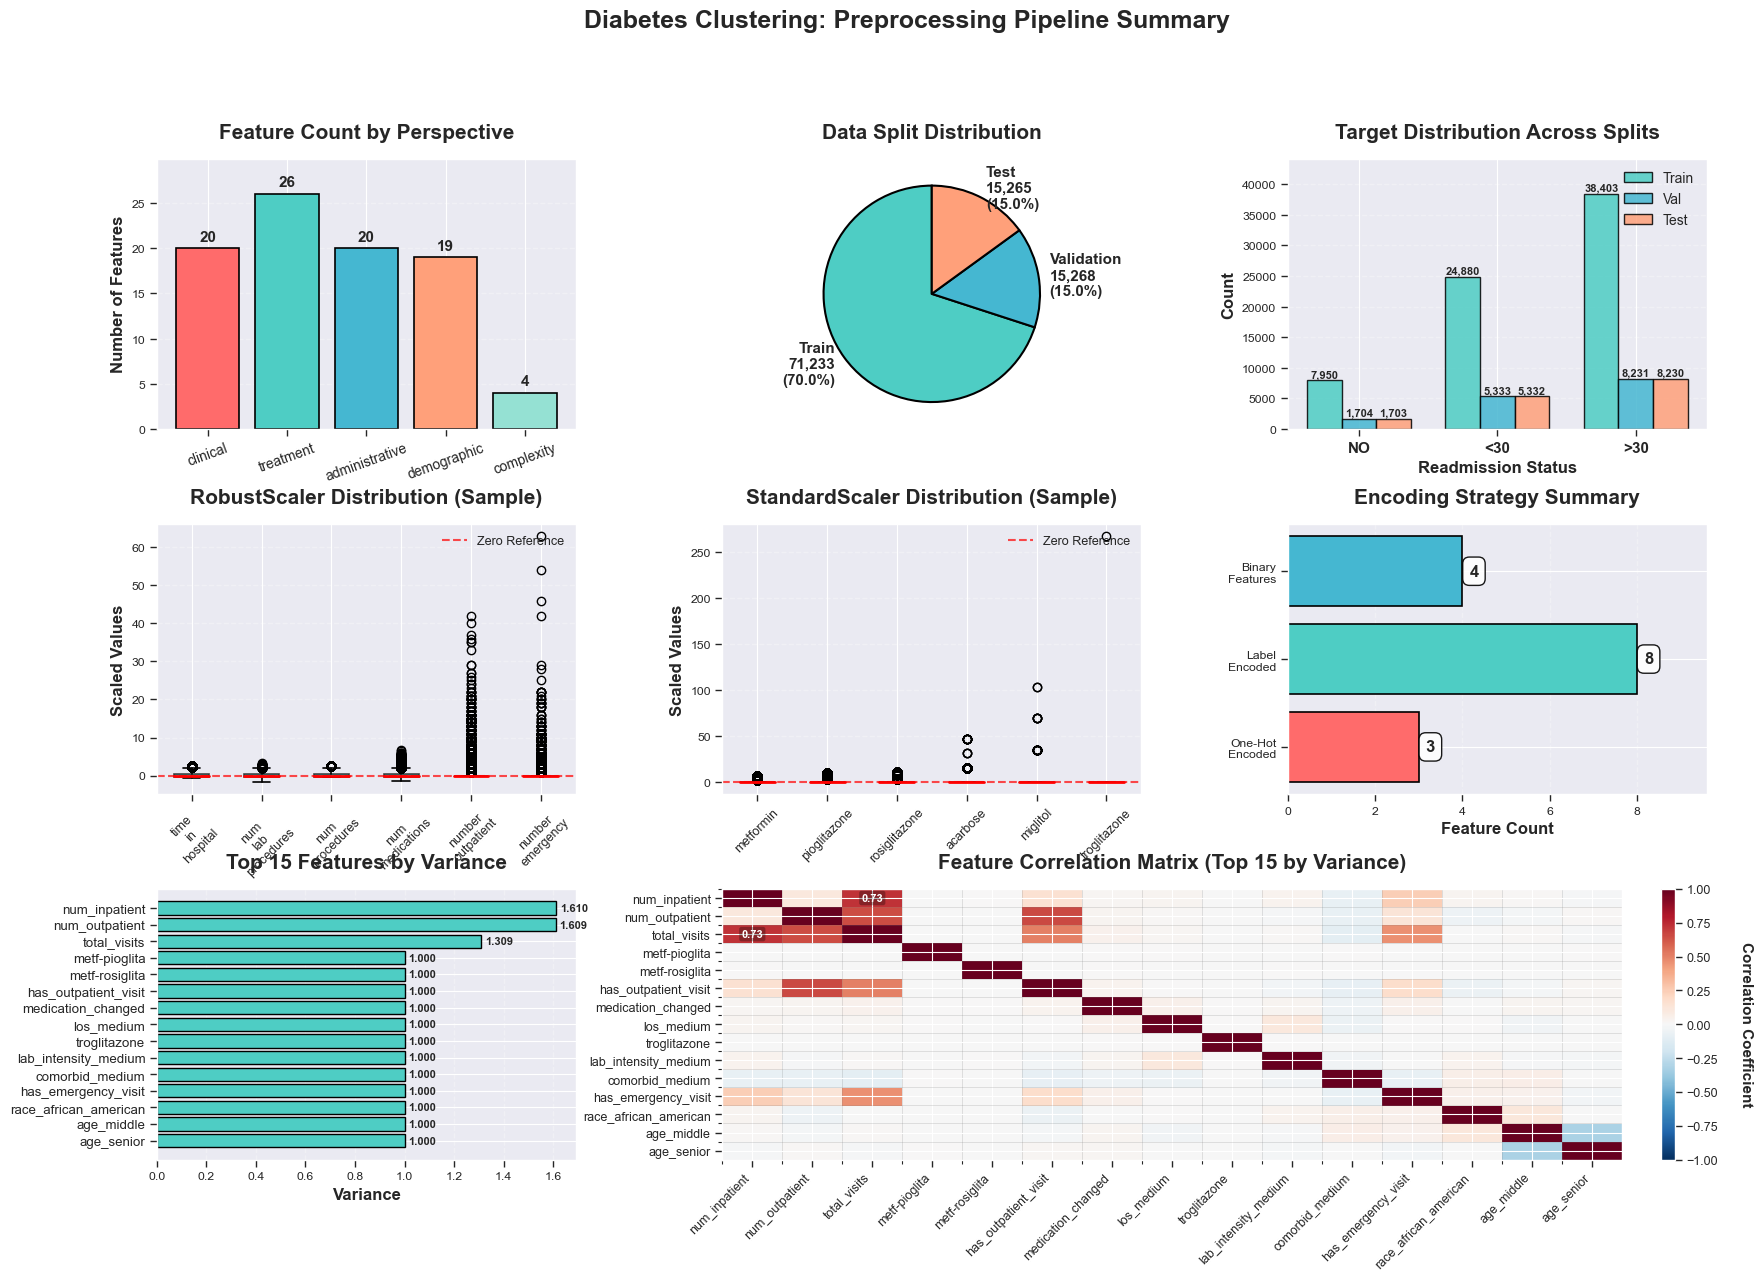


🎯 PREPROCESSING COMPLETE - READY FOR CLUSTERING

📂 Next Step: Run '03_baseline_clustering.ipynb'
   Goal: Establish baseline performance with traditional algorithms
   Algorithms: K-Means, DBSCAN, Hierarchical, GMM
   Metrics: Silhouette, Davies-Bouldin, Calinski-Harabasz


In [43]:
# ============================================================================
# 11. PREPROCESSING PIPELINE SUMMARY & VISUALIZATION
# ============================================================================
print(f"\n{'='*70}")
print("11. PREPROCESSING PIPELINE COMPLETE")
print(f"{'='*70}")

summary_text = f"""
📊 **PREPROCESSING SUMMARY**

**Original Data:**
  - Raw shape: {df.shape}
  - After feature engineering: {df_encoded.shape[0]} rows × {df_encoded.shape[1]} columns
  
**Processed Data:**
  - Final features: {X_train_scaled.shape[1]}
  - Train: {len(X_train_scaled):,} samples ({len(X_train_scaled)/len(X)*100:.1f}%)
  - Validation: {len(X_val_scaled):,} samples ({len(X_val_scaled)/len(X)*100:.1f}%)
  - Test: {len(X_test_scaled):,} samples ({len(X_test_scaled)/len(X)*100:.1f}%)

**Feature Engineering:**
  - Clinical: {len(feature_groups_filtered['clinical'])} features
  - Treatment: {len(feature_groups_filtered['treatment'])} features
  - Administrative: {len(feature_groups_filtered['administrative'])} features
  - Demographic: {len(feature_groups_filtered['demographic'])} features
  - Complexity: {len(feature_groups_filtered['complexity'])} features

**Encoding:**
  - One-Hot: {len(categorical_cols)} features
  - Label Encoded: 8 features (specialty, diagnoses, payer, race, age, weight)

**Scaling:**
  - RobustScaler: {len(robust_features)} features (outlier-resistant)
  - StandardScaler: {len(standard_features)} features

**Output Files (10):**
  ✅ X_train_scaled.csv, X_val_scaled.csv, X_test_scaled.csv
  ✅ y_train.csv, y_val.csv, y_test.csv
  ✅ feature_groups.json
  ✅ preprocessing_summary.json
  ✅ robust_scaler.pkl, standard_scaler.pkl

🎯 **Ready for Multi-Perspective Deep Clustering!**
"""

print(summary_text)

# ============================================================================
# ENHANCED VISUALIZATION WITH FIXES
# ============================================================================
fig = plt.figure(figsize=(20, 13))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.35)

# Color palette
colors_palette = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#95E1D3']
colors_split = ['#4ECDC4', '#45B7D1', '#FFA07A']

# ============================================================================
# 1. Feature count by perspective (TOP LEFT)
# ============================================================================
ax1 = fig.add_subplot(gs[0, 0])
groups = list(feature_groups_filtered.keys())
counts = [len(feature_groups_filtered[g]) for g in groups]
bars = ax1.bar(groups, counts, color=colors_palette[:len(groups)], edgecolor='black', linewidth=1.2)
ax1.set_title('Feature Count by Perspective', fontsize=15, fontweight='bold', pad=15)
ax1.set_ylabel('Number of Features', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

ax1.tick_params(axis='x', rotation=20, labelsize=10)
ax1.set_ylim(0, max(counts) * 1.15)

# ============================================================================
# 2. Sample distribution pie chart (TOP CENTER)
# ============================================================================
ax2 = fig.add_subplot(gs[0, 1])
split_sizes = [len(X_train_scaled), len(X_val_scaled), len(X_test_scaled)]
split_labels = [f'Train\n{len(X_train_scaled):,}\n(70.0%)', 
                f'Validation\n{len(X_val_scaled):,}\n(15.0%)', 
                f'Test\n{len(X_test_scaled):,}\n(15.0%)']

wedges, texts = ax2.pie(split_sizes, labels=split_labels, 
                         colors=colors_split, startangle=90,
                         textprops={'fontsize': 11, 'weight': 'bold'},
                         wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
ax2.set_title('Data Split Distribution', fontsize=15, fontweight='bold', pad=15)

# ============================================================================
# 3. Target distribution across splits (TOP RIGHT) - FIXED
# ============================================================================
ax3 = fig.add_subplot(gs[0, 2])
target_data = {
    'Train': y_train.value_counts().sort_index(),
    'Val': y_val.value_counts().sort_index(),
    'Test': y_test.value_counts().sort_index()
}

readmit_labels = y_train.unique()
x_pos = np.arange(len(readmit_labels))
width = 0.25

# Plot bars with value labels
for i, (split_name, counts) in enumerate(target_data.items()):
    bars = ax3.bar(x_pos + i*width, counts.values, width, 
                   label=split_name, color=colors_split[i], 
                   alpha=0.85, edgecolor='black', linewidth=1)
    
    # Add value labels on each bar
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 200,
                 f'{int(height):,}',
                 ha='center', va='bottom', fontsize=8, fontweight='bold')

ax3.set_title('Target Distribution Across Splits', fontsize=15, fontweight='bold', pad=15)
ax3.set_xlabel('Readmission Status', fontsize=12, fontweight='bold')
ax3.set_ylabel('Count', fontsize=12, fontweight='bold')
ax3.set_xticks(x_pos + width)
ax3.set_xticklabels(readmit_labels, fontsize=11, fontweight='bold')
ax3.legend(loc='upper right', fontsize=10, framealpha=0.9)
ax3.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1)
ax3.set_ylim(0, max([c.max() for c in target_data.values()]) * 1.15)

# ============================================================================
# 4. Feature scaling distribution - RobustScaler (MIDDLE LEFT)
# ============================================================================
ax4 = fig.add_subplot(gs[1, 0])
if len(robust_features) >= 6:
    sample_robust = X_train_scaled[robust_features[:6]]
    bp1 = ax4.boxplot([sample_robust[col] for col in sample_robust.columns],
                       labels=[col.replace('_', '\n')[:25] for col in sample_robust.columns],
                       patch_artist=True,
                       boxprops=dict(facecolor='#4ECDC4', alpha=0.7, edgecolor='black', linewidth=1.2),
                       whiskerprops=dict(color='black', linewidth=1.2),
                       capprops=dict(color='black', linewidth=1.2),
                       medianprops=dict(color='red', linewidth=2))
    
    ax4.set_title('RobustScaler Distribution (Sample)', fontsize=15, fontweight='bold', pad=15)
    ax4.set_ylabel('Scaled Values', fontsize=12, fontweight='bold')
    ax4.tick_params(axis='x', rotation=45, labelsize=9)
    ax4.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=1.5, label='Zero Reference')
    ax4.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1)
    ax4.legend(loc='upper right', fontsize=9)

# ============================================================================
# 5. Feature scaling distribution - StandardScaler (MIDDLE CENTER)
# ============================================================================
ax5 = fig.add_subplot(gs[1, 1])
if len(standard_features) >= 6:
    sample_standard = X_train_scaled[standard_features[:6]]
    bp2 = ax5.boxplot([sample_standard[col] for col in sample_standard.columns],
                       labels=[col.replace('_', '\n')[:25] for col in sample_standard.columns],
                       patch_artist=True,
                       boxprops=dict(facecolor='#45B7D1', alpha=0.7, edgecolor='black', linewidth=1.2),
                       whiskerprops=dict(color='black', linewidth=1.2),
                       capprops=dict(color='black', linewidth=1.2),
                       medianprops=dict(color='red', linewidth=2))
    
    ax5.set_title('StandardScaler Distribution (Sample)', fontsize=15, fontweight='bold', pad=15)
    ax5.set_ylabel('Scaled Values', fontsize=12, fontweight='bold')
    ax5.tick_params(axis='x', rotation=45, labelsize=9)
    ax5.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=1.5, label='Zero Reference')
    ax5.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1)
    ax5.legend(loc='upper right', fontsize=9)

# ============================================================================
# 6. Encoding summary (MIDDLE RIGHT) - FIXED
# ============================================================================
ax6 = fig.add_subplot(gs[1, 2])
encoding_types = ['One-Hot\nEncoded', 'Label\nEncoded', 'Binary\nFeatures']

# FIXED: Accurate count for binary features
binary_count = len([col for col in X_train_scaled.columns if any(x in col for x in 
                    ['_binary', '_flag', '_dependent', '_changed', '_only', '_flag'])])

encoding_counts = [
    len(categorical_cols),  # One-hot
    8,  # Label encoded
    binary_count  # Binary features (accurate count)
]

print(f"\n🔍 Encoding counts verification:")
print(f"  - One-Hot: {encoding_counts[0]}")
print(f"  - Label Encoded: {encoding_counts[1]}")
print(f"  - Binary: {encoding_counts[2]}")

bars_enc = ax6.barh(encoding_types, encoding_counts, 
                     color=['#FF6B6B', '#4ECDC4', '#45B7D1'],
                     edgecolor='black', linewidth=1.2)

ax6.set_title('Encoding Strategy Summary', fontsize=15, fontweight='bold', pad=15)
ax6.set_xlabel('Feature Count', fontsize=12, fontweight='bold')
ax6.grid(axis='x', alpha=0.3, linestyle='--', linewidth=1)
ax6.set_xlim(0, max(encoding_counts) * 1.2)

# Add value labels with better positioning
for bar, count in zip(bars_enc, encoding_counts):
    width = bar.get_width()
    ax6.text(width + max(encoding_counts)*0.02, bar.get_y() + bar.get_height()/2.,
             f'{int(count)}',
             ha='left', va='center', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.4', facecolor='white', 
                      edgecolor='black', linewidth=1, alpha=0.9))

# ============================================================================
# 7. Top 15 features by variance (BOTTOM LEFT) - IMPROVED
# ============================================================================
ax7 = fig.add_subplot(gs[2, 0])
feature_variance = X_train_scaled.var().sort_values(ascending=False).head(15)

# Create abbreviation mapping for better readability
abbrev_mapping = {
    'number_inpatient': 'num_inpatient',
    'number_outpatient': 'num_outpatient',
    'number_emergency': 'num_emergency',
    'metformin-rosiglitazone': 'metf-rosiglita',
    'metformin-pioglitazone': 'metf-pioglita',
    'medication_intensity': 'med_intensity',
    'comorbidity': 'comorbid'
}

labels = []
for label in feature_variance.index:
    short_label = label
    for long, short in abbrev_mapping.items():
        short_label = short_label.replace(long, short)
    labels.append(short_label[:30])  # Max 30 chars

bars_var = ax7.barh(range(len(feature_variance)), feature_variance.values, 
                     color='#4ECDC4', edgecolor='black', linewidth=1)

ax7.set_yticks(range(len(feature_variance)))
ax7.set_yticklabels(labels, fontsize=9.5)
ax7.set_title('Top 15 Features by Variance', fontsize=15, fontweight='bold', pad=15)
ax7.set_xlabel('Variance', fontsize=12, fontweight='bold')
ax7.grid(axis='x', alpha=0.3, linestyle='--', linewidth=1)
ax7.invert_yaxis()

# Add value labels
for i, (bar, val) in enumerate(zip(bars_var, feature_variance.values)):
    ax7.text(val + feature_variance.max()*0.01, bar.get_y() + bar.get_height()/2.,
             f'{val:.3f}',
             ha='left', va='center', fontsize=8, fontweight='bold')

# ============================================================================
# 8. Correlation heatmap of top features (BOTTOM CENTER & RIGHT) - ENHANCED
# ============================================================================
ax8 = fig.add_subplot(gs[2, 1:])

# Select top 15 features by variance for correlation
top_features = feature_variance.head(15).index.tolist()
corr_matrix = X_train_scaled[top_features].corr()

# Abbreviate labels for readability
corr_labels = []
for label in top_features:
    short_label = label
    for long, short in abbrev_mapping.items():
        short_label = short_label.replace(long, short)
    corr_labels.append(short_label[:22])

im = ax8.imshow(corr_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
ax8.set_xticks(range(len(corr_labels)))
ax8.set_yticks(range(len(corr_labels)))
ax8.set_xticklabels(corr_labels, rotation=45, ha='right', fontsize=9)
ax8.set_yticklabels(corr_labels, fontsize=9)
ax8.set_title('Feature Correlation Matrix (Top 15 by Variance)', 
              fontsize=15, fontweight='bold', pad=15)

# Add annotations for high correlations (|r| > 0.7)
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        corr_val = corr_matrix.iloc[i, j]
        if i != j and abs(corr_val) > 0.7:
            text_color = 'white' if abs(corr_val) > 0.5 else 'black'
            ax8.text(j, i, f'{corr_val:.2f}',
                    ha="center", va="center", color=text_color, 
                    fontsize=8, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='black', 
                             alpha=0.3, edgecolor='none'))

# Add colorbar
cbar = plt.colorbar(im, ax=ax8, fraction=0.046, pad=0.04)
cbar.set_label('Correlation Coefficient', rotation=270, labelpad=25, 
               fontsize=11, fontweight='bold')
cbar.ax.tick_params(labelsize=9)

# Add grid lines for better readability
ax8.set_xticks(np.arange(len(corr_labels))-.5, minor=True)
ax8.set_yticks(np.arange(len(corr_labels))-.5, minor=True)
ax8.grid(which="minor", color="gray", linestyle='-', linewidth=0.5, alpha=0.3)



# ============================================================================
# Save high-resolution figure
# ============================================================================
plt.suptitle('Diabetes Clustering: Preprocessing Pipeline Summary', 
             fontsize=18, fontweight='bold', y=0.995)

plt.savefig('reports/figures/preprocessing_summary.png', dpi=600, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
print(f"\n📊 Saved HIGH-RES visualization: reports/figures/preprocessing_summary.png (600 DPI)")

plt.savefig('reports/figures/preprocessing_summary_print.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
print(f"📊 Saved PRINT version: reports/figures/preprocessing_summary_print.png (300 DPI)")

plt.show()

print(f"\n{'='*70}")
print("🎯 PREPROCESSING COMPLETE - READY FOR CLUSTERING")
print(f"{'='*70}")
print(f"\n📂 Next Step: Run '03_baseline_clustering.ipynb'")
print(f"   Goal: Establish baseline performance with traditional algorithms")
print(f"   Algorithms: K-Means, DBSCAN, Hierarchical, GMM")
print(f"   Metrics: Silhouette, Davies-Bouldin, Calinski-Harabasz")


In [44]:
# ============================================================
# SAVE FINAL FEATURE NAMES (69 features after correlation filter)
# ============================================================

print("\n" + "="*60)
print("SAVING FINAL FEATURE NAMES")
print("="*60)

# Get final feature names after all preprocessing
final_feature_names = X_train_scaled.columns.tolist()

print(f"\n✅ Total final features: {len(final_feature_names)}")
print(f"\n📋 First 10 features:")
for i, name in enumerate(final_feature_names[:10], 1):
    print(f"  {i:2d}. {name}")

print(f"\n📋 Last 10 features:")
for i, name in enumerate(final_feature_names[-10:], len(final_feature_names)-9):
    print(f"  {i:2d}. {name}")

# Save as JSON (easy to load)
import json
feature_names_path = 'data/processed/final_feature_names.json'
with open(feature_names_path, 'w') as f:
    json.dump({
        'feature_names': final_feature_names,
        'n_features': len(final_feature_names),
        'source': 'Notebook 02 - Cell 23',
        'preprocessing_steps': [
            'OneHot Encoding',
            'Label Encoding', 
            'RobustScaler + StandardScaler',
            'Variance Threshold (0.01)',
            'Correlation Filter (0.90)'
        ]
    }, f, indent=2)

print(f"\n✅ Feature names saved to: {feature_names_path}")

# Also save as simple text file (backup)
feature_names_txt_path = '../data/processed/final_feature_names.txt'
with open(feature_names_txt_path, 'w') as f:
    for i, name in enumerate(final_feature_names, 1):
        f.write(f"{i:2d}. {name}\n")

print(f"✅ Feature names saved to: {feature_names_txt_path}")

print("\n" + "="*60)
print("✅ FEATURE NAMES SUCCESSFULLY SAVED!")
print("="*60)



SAVING FINAL FEATURE NAMES

✅ Total final features: 93

📋 First 10 features:
   1. time_in_hospital
   2. num_lab_procedures
   3. num_procedures
   4. num_medications
   5. number_outpatient
   6. number_emergency
   7. number_inpatient
   8. number_diagnoses
   9. metformin
  10. pioglitazone

📋 Last 10 features:
  84. change_No
  85. diabetesMed_Yes
  86. medical_specialty_encoded
  87. diag_1_encoded
  88. diag_2_encoded
  89. diag_3_encoded
  90. payer_code_encoded
  91. race_encoded
  92. age_encoded
  93. weight_encoded

✅ Feature names saved to: ../data/processed/final_feature_names.json
✅ Feature names saved to: ../data/processed/final_feature_names.txt

✅ FEATURE NAMES SUCCESSFULLY SAVED!
